In [1]:
import pathlib as pl
import numpy as np
import matplotlib.pyplot as plt

from affine import Affine
import rasterio as rio
from rasterio.plot import show

import flopy

In [2]:
path = pl.Path("../data/lgr_concept/lgr_top.tif")


In [3]:
src = flopy.utils.Raster.load(path)
src.bounds, src.bands

((0.0, 30000.0, 0.0, 30000.0), (1, 2, 3, 4))

In [4]:
top = src.get_array(1)
botm = [
    src.get_array(2),
    src.get_array(3),
    src.get_array(4),
]
    

#### Parent grid

In [5]:
lx = ly = 30000.
nlay, nrow, ncol = 3, 30, 30
shape2d_pg = (nrow, ncol)
shape3d_pg = (nlay, nrow, ncol)
dx, dy = float(lx / ncol), float(ly / nrow)
delr = np.full(ncol, dx, dtype=float)
delc = np.full(nrow, dy, dtype=float)
top_pg = np.ones(shape2d_pg, dtype=float)
botm_pg = np.ones(shape3d_pg, dtype=float)
for k in range(nlay):
    botm_pg[k] = -k

In [6]:
parent_grid = flopy.discretization.StructuredGrid(delc=delc, delr=delr, nlay=nlay, top=top_pg, botm=botm_pg)

In [7]:
top_pg = src.resample_to_grid(
    parent_grid,
    band=src.bands[0],
    method="linear",
    extrapolate_edges=True,
)
for k in range(nlay):
    botm_pg[k] = src.resample_to_grid(
        parent_grid,
        band=src.bands[k + 1],
        method="linear",
        extrapolate_edges=True,
    )

In [8]:
top_pg.min(), top_pg.max()

(5.680462984135779, 13.280876414349338)

##### Create idomain for coarse grid

In [9]:
idomain_pg = np.ones(shape3d_pg, dtype=int)
idomain_pg[:2, 5:15, 5:15] = 0
idomain_pg[:, 20:26, 20:26] = 0

In [10]:
# redefine the grid with the updated top and botm
parent_grid = flopy.discretization.StructuredGrid(delc=delc, delr=delr, nlay=nlay, top=top_pg, botm=botm_pg, idomain=idomain_pg)

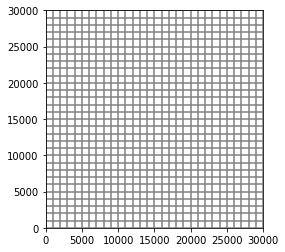

In [11]:
parent_grid.plot()

##### Export coarse grid so it can be used to define the bottom of child 0 and grandchild 0

In [12]:
transform = Affine(dx, 0.0, 0.0, 0.0, -dx, 30000.0)
transform

Affine(1000.0, 0.0, 0.0,
       0.0, -1000.0, 30000.0)

In [13]:
path = pl.Path("data/lgr_coarse_data.tif")
with rio.open(path, 'w', driver="GTiff", width=ncol, height=nrow, dtype=rio.float64, count=4, transform=transform) as dst:
    dst.write_band(1, top_pg[:, :].astype(rio.float64))
    dst.write_band(2, botm_pg[0, :, :].astype(rio.float64))
    dst.write_band(3, botm_pg[1, :, :].astype(rio.float64))
    dst.write_band(4, botm_pg[2, :, :].astype(rio.float64))

In [14]:
src_pg = flopy.utils.Raster.load(path)
src_pg.bounds, src_pg.bands

((0.0, 30000.0, 0.0, 30000.0), (1, 2, 3, 4))

#### Child grid 1

In [15]:
nlay_c0, ncol_c0, nrow_c0 = 4, 30, 30
xoff = 5. * dx
yoff = ly - 15. * dy
dx_c0, dy_c0 = dx / 3., dy / 3

shape2d_c0 = (nrow_c0, ncol_c0)
shape3d_c0 = (nlay_c0, nrow_c0, ncol_c0)
delr_c0 = np.full(ncol_c0, dx_c0, dtype=float)
delc_c0 = np.full(nrow_c0, dy_c0, dtype=float)

In [16]:
top_c0 = np.ones(shape2d_c0, dtype=float)
botm_c0 = np.ones(shape3d_c0, dtype=float)
for k in range(nlay):
    botm_c0[k] = -k

In [17]:
c0_grid = flopy.discretization.StructuredGrid(delc=delc_c0, delr=delr_c0, nlay=nlay_c0, top=top_c0, botm=botm_c0, xoff=xoff, yoff=yoff)

In [18]:
top_c0 = src.resample_to_grid(
    c0_grid,
    band=src.bands[0],
    method="linear",
    extrapolate_edges=True,
)

In [19]:
arrays = (src_pg.bands[1], src_pg.bands[2],)
layers = (1, 3,)
for k, band in zip(layers, arrays):
    botm_c0[k] = src_pg.resample_to_grid(
        c0_grid,
        band=band,
        method="nearest",
        extrapolate_edges=True,
    )
for k in layers:
    if k == 1:
        t = top_c0
    else:
        t = botm_c0[1]
    b = 0.5 * (t - botm_c0[k])
    botm_c0[k - 1] = t - b

##### Create idomain for child grid 1

In [20]:
idomain_c0 = np.ones(shape3d_c0, dtype=int)
idomain_c0[:2, 5:15, 3:13] = 0

In [21]:
# redefine the grid with the updated top and botm
c0_grid = flopy.discretization.StructuredGrid(delc=delc_c0, delr=delr_c0, nlay=nlay_c0, top=top_c0, botm=botm_c0, xoff=xoff, yoff=yoff, idomain=idomain_c0)

#### Grandchild 0

In [22]:
nlay_gc0, ncol_gc0, nrow_gc0 = 3, 30, 30
xoff = 6. * dx
yoff = ly - 10. * dy
dx_gc0, dy_gc0 = dx / 9., dy / 9.

shape2d_gc0 = (nrow_gc0, ncol_gc0)
shape3d_gc0 = (nlay_gc0, nrow_gc0, ncol_gc0)
delr_gc0 = np.full(ncol_gc0, dx_gc0, dtype=float)
delc_gc0 = np.full(nrow_gc0, dy_gc0, dtype=float)

In [23]:
top_gc0 = np.ones(shape2d_gc0, dtype=float)
botm_gc0 = np.ones(shape3d_gc0, dtype=float)
for k in range(nlay):
    botm_gc0[k] = -k

In [24]:
gc0_grid = flopy.discretization.StructuredGrid(delc=delc_gc0, delr=delr_gc0, nlay=nlay_gc0, top=top_gc0, botm=botm_gc0, xoff=xoff, yoff=yoff)

In [25]:
top_gc0 = src.resample_to_grid(
    gc0_grid,
    band=src.bands[0],
    method="linear",
    extrapolate_edges=True,
)

In [26]:
botm_gc0[-1] = src_pg.resample_to_grid(
    gc0_grid,
    band=src_pg.bands[1],
    method="nearest",
    extrapolate_edges=True,
)

b = (top_gc0 - botm_gc0[-1]) / 3.
botm_gc0[0] = top_gc0 - b
botm_gc0[1] = botm_gc0[0] - b

In [27]:
# redefine the grid with the updated top and botm
gc0_grid = flopy.discretization.StructuredGrid(delc=delc_gc0, delr=delr_gc0, nlay=nlay, top=top_gc0, botm=botm_gc0, xoff=xoff, yoff=yoff)

#### Child grid 1

In [28]:
ncol_c1, nrow_c1 = 30, 30
xoff = lx - 10. * dx
yoff = 4. * dy
dx_c1, dy_c1 = dx / 5., dy / 5.

shape2d_c1 = (nrow_c1, ncol_c1)
shape3d_c1 = (nlay, nrow_c1, ncol_c1)
delr_c1 = np.full(ncol_c1, dx_c1, dtype=float)
delc_c1 = np.full(nrow_c1, dy_c1, dtype=float)
top_c1 = np.ones(shape2d_c1, dtype=float)
botm_c1 = np.ones(shape3d_c1, dtype=float)
for k in range(nlay):
    botm_c1[k] = -k


In [29]:
c1_grid = flopy.discretization.StructuredGrid(delc=delc_c1, delr=delr_c1, nlay=nlay, top=top_c1, botm=botm_c1, xoff=xoff, yoff=yoff)

In [30]:
top_c1 = src.resample_to_grid(
    c1_grid,
    band=src.bands[0],
    method="linear",
    extrapolate_edges=True,
)
for k in range(nlay):
    botm_c1[k] = src.resample_to_grid(
        c1_grid,
        band=src.bands[k + 1],
        method="linear",
        extrapolate_edges=True,
    )

In [31]:
# redefine the grid with the updated top and botm
c1_grid = flopy.discretization.StructuredGrid(delc=delc_c1, delr=delr_c1, nlay=nlay, top=top_c1, botm=botm_c1, xoff=xoff, yoff=yoff)

#### Plot the grids

In [32]:
top_c0.min(), top_c0.max()

(5.2085219701434555, 10.059761433444702)

In [33]:
vmin, vmax = top_pg.min(), top_pg.max()
vmin, vmax

(5.680462984135779, 13.280876414349338)

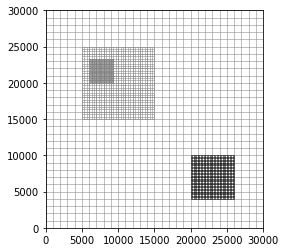

In [34]:
mm = flopy.plot.PlotMapView(modelgrid=parent_grid)
mm.plot_grid(lw=0.5, color="0.5")
# mm.plot_inactive(color_noflow="white", zorder=100)

mm_0 = flopy.plot.PlotMapView(modelgrid=c0_grid, extent=mm.extent)
mm_0.plot_grid(lw=0.5, color="0.5")

mm_gc0 = flopy.plot.PlotMapView(modelgrid=gc0_grid, extent=mm.extent)
mm_gc0.plot_grid(lw=0.5, color="0.5")

mm_1 = flopy.plot.PlotMapView(modelgrid=c1_grid, extent=mm.extent)
mm_1.plot_grid(lw=0.5, color="black")

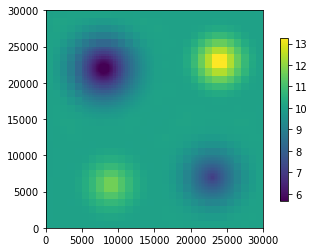

In [35]:
mm = flopy.plot.PlotMapView(modelgrid=parent_grid)
cb_pg = mm.plot_array(parent_grid.top, vmin=vmin, vmax=vmax)
# mm.plot_grid(lw=0.5, color="0.5")

mm_0 = flopy.plot.PlotMapView(modelgrid=c0_grid, extent=mm.extent)
mm_0.plot_array(c0_grid.top, vmin=vmin, vmax=vmax)
# mm_0.plot_grid(lw=0.5, color="0.5")

mm_gc0 = flopy.plot.PlotMapView(modelgrid=gc0_grid, extent=mm.extent)
mm_gc0.plot_array(gc0_grid.top, vmin=vmin, vmax=vmax)
# mm_gc0.plot_grid(lw=0.5, color="0.5")

mm_1 = flopy.plot.PlotMapView(modelgrid=c1_grid, extent=mm.extent)
mm_1.plot_array(c1_grid.top, vmin=vmin, vmax=vmax)
# mm_1.plot_grid(lw=0.5, color="black")

plt.colorbar(cb_pg, shrink=0.75);

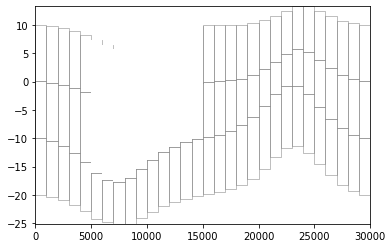

In [36]:
line = [(0, 22500), (lx, 22500)]
cs = flopy.plot.PlotCrossSection(modelgrid=parent_grid, line={"line": line}, geographic_coords=True)
cs.plot_grid(lw=0.5, color="0.5") #, plot_inactive=False)
cs.plot_inactive(color_noflow="white")

# cs_0 = flopy.plot.PlotCrossSection(modelgrid=c0_grid, extent=cs.extent, line={"line": line}, geographic_coords=True)
# cs_0.plot_grid(lw=0.5, color="0.25")
# cs_0.plot_inactive(color_noflow="white")

# cs_gc0 = flopy.plot.PlotCrossSection(modelgrid=gc0_grid, extent=cs.extent, line={"line": line}, geographic_coords=True)
# cs_gc0.plot_grid(lw=0.5, color="0.25")

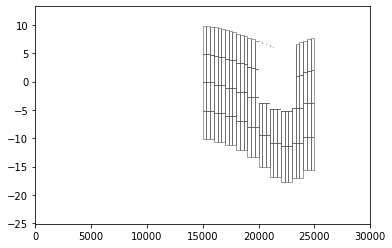

In [37]:
line = [(7000, ly), (7000, 0)]
# cs = flopy.plot.PlotCrossSection(modelgrid=parent_grid, line={"line": line}, geographic_coords=True)
# cs.plot_grid(lw=0.5, color="0.5")
# cs.plot_inactive(color_noflow="white")

cs_0 = flopy.plot.PlotCrossSection(modelgrid=c0_grid, extent=cs.extent, line={"line": line}, geographic_coords=True)
cs_0.plot_grid(lw=0.5, color="0.25")
cs_0.plot_inactive(color_noflow="white")

# cs_gc0 = flopy.plot.PlotCrossSection(modelgrid=gc0_grid, extent=cs.extent, line={"line": line}, geographic_coords=True)
# cs_gc0.plot_grid(lw=0.5, color="0.25")

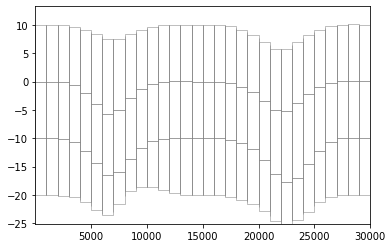

In [38]:
line = [(0, ly), (lx, 0)]
cs = flopy.plot.PlotCrossSection(modelgrid=parent_grid, line={"line": line}, geographic_coords=True)
cs.plot_grid(lw=0.5, color="0.5") #, show_inactive=False)

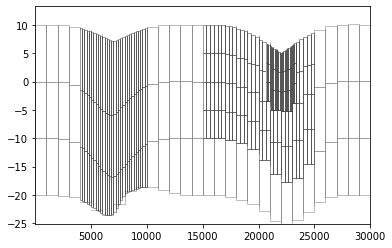

In [39]:
line = [(0, ly), (lx, 0)]
cs = flopy.plot.PlotCrossSection(modelgrid=parent_grid, line={"line": line}, geographic_coords=True)
cs.plot_grid(lw=0.5, color="0.5") #, show_inactive=False)
cs.plot_inactive(color_noflow="white")

cs_0 = flopy.plot.PlotCrossSection(modelgrid=c0_grid, extent=cs.extent, line={"line": line}, geographic_coords=True)
cs_0.plot_grid(lw=0.5, color="0.25")
cs_0.plot_inactive(color_noflow="white")

cs_gc0 = flopy.plot.PlotCrossSection(modelgrid=gc0_grid, extent=cs.extent, line={"line": line}, geographic_coords=True)
cs_gc0.plot_grid(lw=0.5, color="0.25")

cs_1 = flopy.plot.PlotCrossSection(modelgrid=c1_grid, extent=cs.extent, line={"line": line}, geographic_coords=True)
cs_1.plot_grid(lw=0.5, color="0.25")
